<img src="./figs/IOAI-Logo.png" alt="IOAI Logo" width="200" height="auto">

[IOAI 2025 (Beijing, China), Individual Contest](https://ioai-official.org/china-2025)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IOAI-official/IOAI-2025/blob/main/Individual-Contest/Restroom/Restroom.ipynb)

## Restroom Icon Matching

## 1. Problem Description

This task focuses on training a model to learn the relationship between **male and female restroom icons from the same restroom**. Based on labeled training data, you are required to train a matching model that, given a query image, finds its **cross-gender counterpart** (e.g., match a male icon in its cropped image to its female counterpart in its original image), under the constraint that both icons come from the **same restroom**.

For example, for a query image (i.e., a male icon in cropped image) shown below in Fig1, its corresponding counterpart is shown in Fig2 (i.e., a female icon in original image which is from the same restroom).

| <img src="./figs/Restroom Fig 1.png" height="200"> | <img src="./figs/Restroom Fig 2.png" height="200"> |
| ------------------------------------------------------------ | ------------------------------------------------------------ |



## 2. Dataset

**(1) Training Set:** 

Used for model training. Directory structure:

```bash
train/
├── crop/         # Cropped icons
│   ├── female/   1.png, 2.png, ...
│   └── male/
└── orig/         # Original icons
    ├── female/
    └── male/
```

Each subfolder contains icons named from `1.png` to `82.png`, where the number indicates the restroom ID. For each restroom, there are four images (note that four images from the same restroom will share one same unique id across all four subfolders):

- `crop/female/i.png` → Cropped female icon  
- `crop/male/i.png`  → Cropped male icon  
- `orig/female/i.png` → Original female icon  
- `orig/male/i.png`  → Original male icon  

**(2) Validation Set and Test Set:** 

Either the validation set (test_a) or the test set (test_b) contains two subfolders:

```bash
test_a/           (or test_b/)
├── query/        # Cropped icons to be matched
└── gallery/      # Candidate original icons
```

- `query/`: **cropped** icons that need to be matched.  
- `gallery/`: pool of **original** icons to match from.  
- Note that:
    - Unlike the training split, the filenames in `query/` and `gallery/` are independently numbered and shuffled, which means that matching cannot rely on the ids
    - For each cropped icon in `query/` there are exactly two originals in `gallery/` (one male, one female from the same restroom), which means $\text{len}(\text{gallery})=2 * \text{len}(\text{query})$
- All images are in `.png` format. 
- The validation set has $10$ images in its `query/` folder, and the test set has $30$ images in its `query/` folder.

## 3. Task

For each image in the `query/` folder, predict the image in `gallery/` that:
- Is of the **opposite gender**, and
- Comes from the **same restroom**

This matching should be accomplished **using your trained model**. 

## 4. Submission Requirements

You must submit a notebook named `submission.ipynb`, which should include:

- Model training process (using `train/` data)  
- Matching process for both test sets (`test_a/` and `test_b/`)  
- The notebook must output two `.npy` files:
```bash
submission_a.npy     # Matching results for validation set (test_a).
submission_b.npy     # Matching results for test set (test_b).
```

Each npz file is a one-dimensional array with a size equal to the number of queries, and each value in the array corresponds to the image ID in the gallery.

For example, one valid `submission_a.npy` may looks like this:
<img src="./figs/Restroom Fig 3.png" width="300">

You can also find an example output format in [baseline.ipynb](https://ioai.bohrium.com/notebooks/81153159178).

## 5. Score

- If the submission finishes within the time limit, the score is calculated as:  
  $$
  \text{Score} = \frac{\text{Number of correct matches}}{\text{Total queries}}
  $$
  
  which will be a float number between $0.0$ and $1.0$ (inclusive).
  
- Submissions that exceed the time limit will receive a score of **0**.

## 6. Baseline and Training Set

- Below you can find the baseline solution.
- The dataset is in `training_set` folder. 
- The highest score by the Scientific Committee for this task is $0.90$ in Leaderboard B,  this score is used for score unification.
- The baseline score by the Scientific Committee for this task is $0.77$ in Leaderboard B,  this score is used for score unification.


In [76]:
import random
import numpy as np
import torch
from pathlib import Path
from tqdm import tqdm
import os
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import cv2
from torchvision import models
import matplotlib.pyplot as plt
from torchvision import transforms


seed = 42

random.seed(seed)                  # Python built-in random
np.random.seed(seed)               # NumPy
torch.manual_seed(seed)            # PyTorch (CPU)
torch.cuda.manual_seed(seed)       # PyTorch (single GPU)
torch.cuda.manual_seed_all(seed)   # PyTorch (all GPUs)

# Ensures deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [77]:
def sort_paths_by_number(path_list):
    """
    Sort based on the numerical values of the filenames in the path,
    assuming all filenames can be converted to integers.
    """
    def get_file_number(path):
        file_name = os.path.splitext(os.path.basename(path))[0]
        return int(file_name)

    path_list.sort(key=get_file_number)

In [78]:
# import clip-vit model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
%pip install --quiet git+https://github.com/openai/CLIP.git
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)
model = model.float()

import os

  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [79]:
class SiameseCLIP(nn.Module):
    def __init__(self, clip_model, out_dim=256):
        super().__init__()
        self.encoder = clip_model.visual  # CLIP visual backbone

        # optional projection head (recommended)
        self.proj = nn.Sequential(
            nn.Linear(clip_model.visual.output_dim, out_dim),
            nn.BatchNorm1d(out_dim)
        )

    def forward(self, x):
        feat = self.encoder(x)
        feat = self.proj(feat)
        feat = F.normalize(feat, dim=1)
        return feat

siamese = SiameseCLIP(model)

In [80]:
def triplet_loss(anchor, positive, negative, margin=0.5):
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = F.pairwise_distance(anchor, negative)
    return torch.relu(pos_dist - neg_dist + margin).mean()


In [81]:
class ClipPairDataset(Dataset):
    def __init__(self, root, preprocess):
        self.pairs = []
        self.preprocess = preprocess

        crop_root = Path(root) / "crop"
        orig_root = Path(root) / "orig"

        for gender in ["male", "female"]:
            opp = "female" if gender == "male" else "male"
            for p in (crop_root / gender).glob("*.png"):
                self.pairs.append((
                    p,
                    orig_root / opp / p.name
                ))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        q, g = self.pairs[idx]
        q = self.preprocess(Image.open(q))
        g = self.preprocess(Image.open(g))
        return q, g

class SiameseDataset(Dataset):
    def __init__(self, root, preprocess):
        self.base = ClipPairDataset(root, preprocess)
        self.all_targets = [p[1] for p in self.base.pairs]
        self.preprocess = preprocess

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        q, g_pos = self.base.pairs[idx]

        # positive
        q_img = self.preprocess(Image.open(q))
        g_pos_img = self.preprocess(Image.open(g_pos))

        # negative (random other target)
        neg_idx = torch.randint(0, len(self.all_targets), (1,)).item()
        g_neg = self.all_targets[neg_idx]
        g_neg_img = self.preprocess(Image.open(g_neg))

        return q_img, g_pos_img, g_neg_img

dataset = SiameseDataset(
    root="/kaggle/input/training-set/training_set",
    preprocess=preprocess
)

loader = DataLoader(
    dataset,
    batch_size=12,    
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

In [82]:
def train_siamese(
    model,
    loader,
    optimizer,
    device,
    epochs=10
):
    model.train()
    model.to(device)

    for epoch in range(epochs):
        total_loss = 0.0

        for q, g_pos, g_neg in loader:
            q = q.to(device)
            g_pos = g_pos.to(device)
            g_neg = g_neg.to(device)

            z_q = model(q)
            z_pos = model(g_pos)
            z_neg = model(g_neg)

            loss = triplet_loss(z_q, z_pos, z_neg)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}: {total_loss / len(loader):.4f}")

    return model

# freeze most of CLIP
for p in siamese.encoder.parameters():
    p.requires_grad = False

# unfreeze projection head
for p in siamese.proj.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(
    siamese.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

siamese = train_siamese(siamese, loader, optimizer, DEVICE)

Epoch 1: 0.1278
Epoch 2: 0.0586
Epoch 3: 0.0214
Epoch 4: 0.0102
Epoch 5: 0.0094
Epoch 6: 0.0166
Epoch 7: 0.0053
Epoch 8: 0.0081
Epoch 9: 0.0066
Epoch 10: 0.0161


In [83]:
def infer(img_paths):
    embeddings = []

    siamese.eval()

    for path in tqdm(img_paths):
        img = Image.open(path).convert("RGB")

        x = preprocess(img)
        x = x.float().unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            emb = siamese(x)   # ← Siamese network

        embeddings.append(emb)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = F.normalize(embeddings, p=2, dim=1)

    return embeddings


In [84]:
def collect_paths_and_labels(root):
    """
    Returns:
      paths: list[str]
      labels: list[int]
        0 = crop (query)
        1 = orig (target)
    """
    crop_root = Path(root) / "crop"
    orig_root = Path(root) / "orig"

    paths = []
    labels = []

    for gender in ["male", "female"]:
        opp = "female" if gender == "male" else "male"

        for p in (crop_root / gender).glob("*.png"):
            # query (crop)
            paths.append(str(p))
            labels.append(0)

            # target (orig)
            paths.append(str(orig_root / opp / p.name))
            labels.append(1)

    return paths, labels

paths, labels = collect_paths_and_labels('/kaggle/input/training-set/training_set')

embeddings = infer(paths)    # (N, D), normalized
embeddings = embeddings.cpu().numpy()
labels = np.array(labels)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

100%|██████████| 328/328 [00:04<00:00, 79.39it/s]


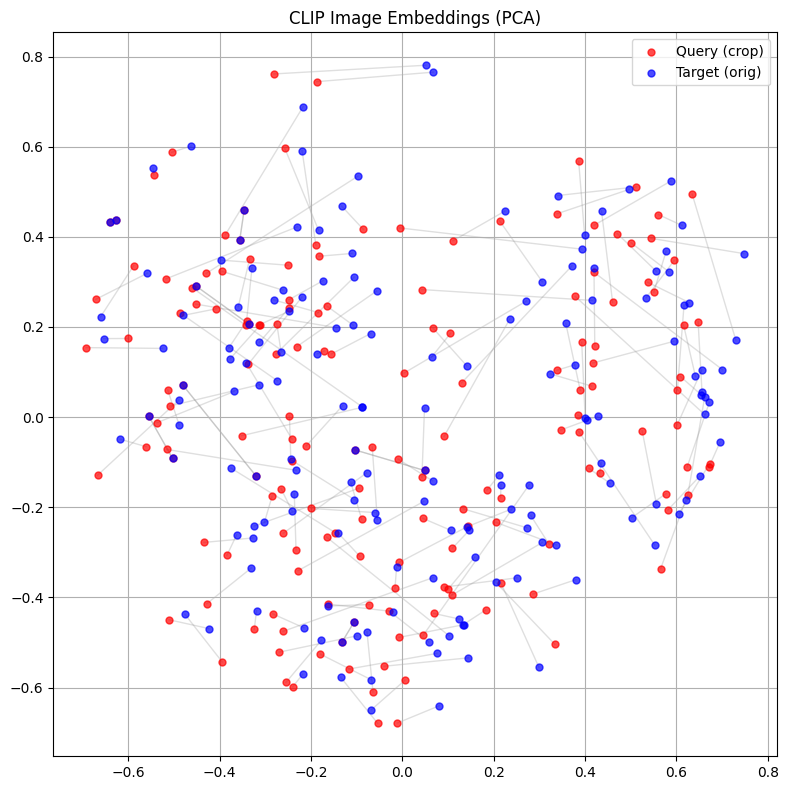

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# ---- draw pair connections FIRST (background) ----
for i in range(0, len(emb_2d), 2):
    plt.plot(
        emb_2d[i:i+2, 0],
        emb_2d[i:i+2, 1],
        c="gray",
        alpha=0.25,
        linewidth=1,
        zorder=1
    )

# ---- draw query points ----
plt.scatter(
    emb_2d[labels == 0, 0],
    emb_2d[labels == 0, 1],
    c="red",
    label="Query (crop)",
    alpha=0.7,
    s=25,
    zorder=2
)

# ---- draw target points ----
plt.scatter(
    emb_2d[labels == 1, 0],
    emb_2d[labels == 1, 1],
    c="blue",
    label="Target (orig)",
    alpha=0.7,
    s=25,
    zorder=2
)

plt.title("CLIP Image Embeddings (PCA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
import torch
import numpy as np

# back to torch for cosine math
emb = torch.from_numpy(embeddings)  # (N, D)

pos_sims = []
hard_neg_sims = []

for i in range(0, len(emb), 2):
    q = emb[i]        # query
    pos = emb[i + 1]  # true target

    # cosine similarity with true match
    pos_sim = torch.dot(q, pos).item()
    pos_sims.append(pos_sim)

    # cosine similarity with all other targets
    all_targets = emb[1::2]                 # all orig embeddings
    neg_sims = torch.mv(all_targets, q)     # cosine sims

    # remove the true target
    neg_sims = torch.cat([
        neg_sims[: i // 2],
        neg_sims[i // 2 + 1 :]
    ])

    hard_neg_sims.append(neg_sims.max().item())

pos_sims = np.array(pos_sims)
hard_neg_sims = np.array(hard_neg_sims)


print("Positive cosine similarity:")
print("  mean:", pos_sims.mean())
print("  min :", pos_sims.min())

print("\nHardest negative cosine similarity:")
print("  mean:", hard_neg_sims.mean())
print("  max :", hard_neg_sims.max())

print("\nMean margin (pos - hardest_neg):")
print(" ", (pos_sims - hard_neg_sims).mean())


Positive cosine similarity:
  mean: 0.8370759381753642
  min : 0.6283589005470276

Hardest negative cosine similarity:
  mean: 0.8779813927121278
  max : 1.0000001192092896

Mean margin (pos - hardest_neg):
  -0.040905454536763634


In [87]:
correct = 0
total = len(pos_sims)

for i in range(0, len(emb), 2):
    q = emb[i]
    sims = torch.mv(emb[1::2], q)
    pred = sims.argmax().item()

    if pred == i // 2:
        correct += 1

print("Top-1 retrieval accuracy:", correct / total)

Top-1 retrieval accuracy: 0.27439024390243905


In [88]:
siamese.eval()

def match_images(BASE_DATA_DIR, result_path):
    QUERY_DIR = BASE_DATA_DIR / "query"
    NON_QUERY_DIR = BASE_DATA_DIR / "gallery"

    query_image_paths = list(QUERY_DIR.glob("*.png"))
    non_query_image_paths = list(NON_QUERY_DIR.glob("*.png"))

    query_image_paths_str = [str(p) for p in query_image_paths]
    non_query_image_paths_str = [str(p) for p in non_query_image_paths]

    sort_paths_by_number(query_image_paths_str)
    sort_paths_by_number(non_query_image_paths_str)

    # --- Siamese embeddings ---
    query_embeddings = infer(query_image_paths_str)       # (Q, D)
    non_query_embeddings = infer(non_query_image_paths_str)  # (G, D)

    sims = query_embeddings @ non_query_embeddings.T

    # top-2 matches
    top2 = sims.topk(2, dim=1).indices  # shape (Q, 2)
    
    # take second-best
    matches_idxs = top2[:, 1].cpu().numpy()


    # convert to 1-based indexing
    matches_idxs += 1

    np.save(result_path, matches_idxs)

In [89]:
"""the generated submission should be two .npy files"""
DATA_PATH = Path("/kaggle/input/restroom-validation/")
OUTPUT_PATH = Path('/kaggle/working')

match_images(DATA_PATH / "validation_set", OUTPUT_PATH / "submission_a.npy")
match_images(DATA_PATH / "test_set", OUTPUT_PATH / "submission_b.npy")

100%|██████████| 60/60 [00:00<00:00, 76.49it/s]


In [90]:
!cp /kaggle/input/restroom-validation/Scoring/metrics.py .
!cp /kaggle/input/restroom-validation/Scoring/answer_a.npy .
!cp /kaggle/input/restroom-validation/Scoring/answer_b.npy .

!python metrics.py

Starting evaluation...

=== Evaluating Test Set A ===
Loaded ground truth /kaggle/working/answer_a.npy: shape (10,), dtype int64
Loaded /kaggle/working/submission_a.npy: shape (10,), dtype int64
Test Set A - Precision@1: 1.00
Test Set A - Correct predictions: 10/10

=== Evaluating Test Set B ===
Loaded ground truth /kaggle/working/answer_b.npy: shape (30,), dtype int64
Loaded /kaggle/working/submission_b.npy: shape (30,), dtype int64
Test Set B - Precision@1: 0.83
Test Set B - Correct predictions: 25/30

Results saved to /kaggle/working/score.json

=== EVALUATION SUMMARY ===
Status: True
Test Set A (public) Score: 1.00
Test Set B (private) Score: 0.83
Message: Success!
